**Mutli-Modal Material Classifier For Material Selection**

In [11]:
# If getting errors here, make sure you have necessary libraries installed
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from autogluon.tabular import TabularDataset, TabularPredictor
from autogluon.tabular import TabularDataset, TabularPredictor
from autogluon.common.utils.utils import setup_outputdir
from autogluon.core.utils.loaders import load_pkl
from autogluon.core.utils.savers import save_pkl
import os.path
from sklearn.metrics import multilabel_confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import tensorflow as tf
from autogluon.tabular import TabularPredictor
from sklearn.preprocessing import LabelEncoder
import shap as shap
import tkinter as tk
from tkinter import ttk
import shutil
import os
import random

**Data Preprocessing**

Classify the data through parsing of keywords in each material description.

In [12]:
# Read data from file
# Rename for your device as necessary
filename = "Data.csv"
df = pd.read_csv(filename)
display(df)

def parse_and_compare(input_string, keywords):
    # Normalize input string and tokenize
    words = set(input_string.lower().split())
    # Check for intersection with each keyword group
    for label, key_group in keywords.items():
        if words.intersection(key_group):
            return label
    return 'Unspecified'

# Keywords dictionary
keywords = {
    'Steel': {'steel', 'sae', 'en', 'din', 'bs', 'csn', 'nf', 'jis'},
    'Aluminum': {'aluminum'},
    'Iron': {'iron', 'grey', 'cast', 'nodular'},
    'Brass': {'brass', 'red', 'semi-red', 'yellow'},
    'Copper': {'copper', 'high-copper'},
    'Bronze': {'bronze', 'phosphor', 'tin', 'lead', 'silicon', 'manganese'},
    'Magnesium': {'magnesium'}
}

# Apply parsing function to the entire 'Material' column
df['Label'] = df['Material'].apply(lambda x: parse_and_compare(x, keywords))

df['Sy'] = df['Sy'].str.replace(' max', '').astype(int)

# Drop the unused columns
df.drop(['Std','ID', 'Heat treatment', 'Desc','A5','Bhn','pH','Desc','HV'], axis=1, inplace=True)

# Add the 'Use' column  ---> Broad material selection, not massively applicable
# df['Use'] = (
#     (df['Su'].between(336, 505)) &
#     (df['Sy'].between(251, 376)) &
#     (df['E'].between(165000, 248000)) &
#     (df['G'].between(63000, 94000)) &
#     (df['mu'].between(0.24, 0.36)) &
#     (df['Ro'].between(6200, 9400))
# ).map({True: 'True', False: 'False'})

# Insert the 'Use' column at the second position
# df.insert(7, 'Use', df.pop('Use'))

# Write the updated data to a new file
df.to_csv('BigMaterialGroups.csv', index=False)
display(df)

,Std,ID,Material,Heat treatment,Su,Sy,A5,Bhn,E,G,mu,Ro,pH,Desc,HV
0,ANSI,D8894772B88F495093C43AF905AB6373,Steel SAE 1015,as-rolled,421,314,39.0,126.0,207000,79000,0.30,7860,NaN,NaN,NaN
1,ANSI,05982AC66F064F9EBC709E7A4164613A,Steel SAE 1015,normalized,424,324,37.0,121.0,207000,79000,0.30,7860,NaN,NaN,NaN
2,ANSI,356D6E63FF9A49A3AB23BF66BAC85DC3,Steel SAE 1015,annealed,386,284,37.0,111.0,207000,79000,0.30,7860,NaN,NaN,NaN
3,ANSI,1C758F8714AC4E0D9BD8D8AE1625AECD,Steel SAE 1020,as-rolled,448,331,36.0,143.0,207000,79000,0.30,7860,NaN,NaN,NaN
4,ANSI,DCE10036FC1946FC8C9108D598D116AD,Steel SAE 1020,normalized,441,346,35.8,131.0,207000,79000,0.30,7860,550.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1547,JIS,512A80EC21EA416BA2725B38BA8096EF,Nodular cast iron,NaN,600,370,NaN,NaN,169000,70000,0.20,7160,480.0,Nodular cast iron,210.0
1548,JIS,38526441BA8741CA979DBF870D0B8A9B,Nodular cast iron,NaN,700,420,NaN,NaN,169000,70000,0.20,7160,560.0,Nodular cast iron,230.0
1549,JIS,CAC03D7EB1AA45E68EFF92A2EF4C3D9B,Nodular cast iron,NaN,800,480,NaN,NaN,169000,70000,0.20,7160,600.0,Nodular cast iron,240.0
1550,JIS,45C82A36EC644F8BB6170A99ED819B62,Malleable cast iron,NaN,400,180,4.0,NaN,160000,64000,0.27,7160,300.0,Malleable cast iron,220.0


,Material,Su,Sy,E,G,mu,Ro,Label
0,Steel SAE 1015,421,314,207000,79000,0.30,7860,Steel
1,Steel SAE 1015,424,324,207000,79000,0.30,7860,Steel
2,Steel SAE 1015,386,284,207000,79000,0.30,7860,Steel
3,Steel SAE 1020,448,331,207000,79000,0.30,7860,Steel
4,Steel SAE 1020,441,346,207000,79000,0.30,7860,Steel
...,...,...,...,...,...,...,...,...
1547,Nodular cast iron,600,370,169000,70000,0.20,7160,Iron
1548,Nodular cast iron,700,420,169000,70000,0.20,7160,Iron
1549,Nodular cast iron,800,480,169000,70000,0.20,7160,Iron
1550,Malleable cast iron,400,180,160000,64000,0.27,7160,Iron


Data Preperation w/ Finer Class Granularity

In [13]:
# Read data from file
# Rename for your device as necessary
filename = "Data.csv"
df = pd.read_csv(filename)
display(df)

def parse_and_compare(input_string, granular_keywords, big_keywords):
    # Normalize input string and tokenize
    words = set(input_string.lower().split())
    
    # First, try to match with granular keywords
    for label, key_group in granular_keywords.items():
        if key_group.issubset(words):
            return label
    
    # If no granular match, try to match with big keywords
    for label, key_group in big_keywords.items():
        if words.intersection(key_group):
            return label

    return 'Unspecified'

# Keywords dictionaries
granular_keywords = {
    'Grey Cast Iron': {'grey', 'cast', 'iron'},
    'Nodular Cast Iron': {'nodular', 'cast', 'iron'},
    'Malleable Cast Iron': {'malleable', 'cast', 'iron'},
    'Red Brass': {'red', 'brass'},
    'Semi-Red Brass': {'semi-red', 'brass'},
    'Yellow Brass': {'yellow', 'brass'},
    'Manganese Bronze': {'manganese', 'bronze'},
    'Silicon Bronze': {'silicon', 'bronze'},
    'Tin Bronze': {'tin', 'bronze'},
    'Leaded Tin Bronze': {'lead', 'tin', 'bronze'},
    'Nickel-Tin Bronze': {'nickel-tin', 'bronze'},
    'Aluminum Bronze': {'aluminum', 'bronze'},
    'Nickel Silver': {'nickel', 'silver'},
    'Special Alloy': {'special', 'alloy'}
}
big_keywords = {
    'Steel': {'steel', 'sae', 'en', 'din', 'bs', 'csn', 'nf', 'jis'},
    'Aluminum': {'aluminum'},
    'Iron': {'iron', 'grey', 'cast', 'nodular'},
    'Brass': {'brass', 'red', 'semi-red', 'yellow'},
    'Copper': {'copper', 'high-copper'},
    'Bronze': {'bronze', 'phosphor', 'tin', 'lead', 'silicon', 'manganese'},
    'Magnesium': {'magnesium'},
    'Copper-Nickel': {'copper-nickel'}
}

# Apply parsing function to the entire 'Material' column
df['Label'] = df['Material'].apply(lambda x: parse_and_compare(x, granular_keywords, big_keywords))

df['Sy'] = df['Sy'].str.replace(' max', '').astype(int)

# Drop the unused columns
df.drop(['Std','ID', 'Heat treatment', 'Desc','A5','Bhn','pH','Desc','HV'], axis=1, inplace=True)

# Write the updated data to a new files
df.to_csv('FineGranularityMaterialGroups.csv', index=False)
display(df)

,Std,ID,Material,Heat treatment,Su,Sy,A5,Bhn,E,G,mu,Ro,pH,Desc,HV
0,ANSI,D8894772B88F495093C43AF905AB6373,Steel SAE 1015,as-rolled,421,314,39.0,126.0,207000,79000,0.30,7860,NaN,NaN,NaN
1,ANSI,05982AC66F064F9EBC709E7A4164613A,Steel SAE 1015,normalized,424,324,37.0,121.0,207000,79000,0.30,7860,NaN,NaN,NaN
2,ANSI,356D6E63FF9A49A3AB23BF66BAC85DC3,Steel SAE 1015,annealed,386,284,37.0,111.0,207000,79000,0.30,7860,NaN,NaN,NaN
3,ANSI,1C758F8714AC4E0D9BD8D8AE1625AECD,Steel SAE 1020,as-rolled,448,331,36.0,143.0,207000,79000,0.30,7860,NaN,NaN,NaN
4,ANSI,DCE10036FC1946FC8C9108D598D116AD,Steel SAE 1020,normalized,441,346,35.8,131.0,207000,79000,0.30,7860,550.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1547,JIS,512A80EC21EA416BA2725B38BA8096EF,Nodular cast iron,NaN,600,370,NaN,NaN,169000,70000,0.20,7160,480.0,Nodular cast iron,210.0
1548,JIS,38526441BA8741CA979DBF870D0B8A9B,Nodular cast iron,NaN,700,420,NaN,NaN,169000,70000,0.20,7160,560.0,Nodular cast iron,230.0
1549,JIS,CAC03D7EB1AA45E68EFF92A2EF4C3D9B,Nodular cast iron,NaN,800,480,NaN,NaN,169000,70000,0.20,7160,600.0,Nodular cast iron,240.0
1550,JIS,45C82A36EC644F8BB6170A99ED819B62,Malleable cast iron,NaN,400,180,4.0,NaN,160000,64000,0.27,7160,300.0,Malleable cast iron,220.0


,Material,Su,Sy,E,G,mu,Ro,Label
0,Steel SAE 1015,421,314,207000,79000,0.30,7860,Steel
1,Steel SAE 1015,424,324,207000,79000,0.30,7860,Steel
2,Steel SAE 1015,386,284,207000,79000,0.30,7860,Steel
3,Steel SAE 1020,448,331,207000,79000,0.30,7860,Steel
4,Steel SAE 1020,441,346,207000,79000,0.30,7860,Steel
...,...,...,...,...,...,...,...,...
1547,Nodular cast iron,600,370,169000,70000,0.20,7160,Nodular Cast Iron
1548,Nodular cast iron,700,420,169000,70000,0.20,7160,Nodular Cast Iron
1549,Nodular cast iron,800,480,169000,70000,0.20,7160,Nodular Cast Iron
1550,Malleable cast iron,400,180,160000,64000,0.27,7160,Malleable Cast Iron


Split and Scale the data

In [13]:
def process_dataset(filename, target, onehot = False, scaling = True):
    """Apply one-hot encoding and scaling to the dataset as necessary"""

    df = pd.read_csv(filename)
    df = df.drop(['Material'], axis=1) # MAY REMOVE IN FURTURE ITERATIONS

    # Separate features and target
    X = df.drop(target, axis=1)
    Y = df[target]
    if onehot:
        X = OH_encode(X)

    # Filter out outliers (confirm if this work with onehot encoding)
    for col in df.columns:
        # Skip the target column
        if col == target:
            continue
        upper_limit = df[col].quantile(0.99)
        df = df[df[col] <= upper_limit]

    # Split the dataset into training and testing sets
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=random.randint(0, 10000))

    scaler = StandardScaler()
    if scaling:
        # Initialize StandardScaler
        

        # Fit the scaler on the training data and transform both training and testing data
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Reconstruct the DataFrame from scaled data
        train_data = pd.DataFrame(X_train_scaled, columns=X_train.columns)
        train_data = pd.concat([train_data, Y_train.reset_index(drop=True)], axis=1)

        test_data = pd.DataFrame(X_test_scaled, columns=X_test.columns)
        test_data['target'] = Y_test.reset_index(drop=True)
    else: # Simply use the unscaled data
        train_data = pd.concat([X_train.reset_index(drop=True), Y_train.reset_index(drop=True)], axis=1)
        test_data = pd.concat([X_test.reset_index(drop=True), Y_test.reset_index(drop=True)], axis=1)
        test_data.rename(columns={target: 'target'}, inplace=True)
        
    return train_data, test_data, scaler

def OH_encode(data):
    data=data.copy()
    #One-hot encode the materials
    data.loc[:, "Material"]=pd.Categorical(data["Material"], categories=["Steel", "Aluminum", "Titanium"])
    mats_oh=pd.get_dummies(data["Material"], prefix="Material=", prefix_sep="")
    data.drop(["Material"], axis=1, inplace=True)
    data=pd.concat([mats_oh, data], axis=1)
    return data


**Performance Metrics Functions**

In [14]:
def printScores(y_val, class_pred, average='weighted'): #proba):
    f1 = f1_score(y_val, class_pred, average='weighted')
    precision = precision_score(y_val, class_pred, average='weighted')
    recall = recall_score(y_val, class_pred, average='weighted')
    accuracy = accuracy_score(y_val, class_pred)
    #auc = roc_auc_score(y_val, proba)
    print(multilabel_confusion_matrix(y_val, class_pred, labels=[0, 1]))
    print("F1: " + str(f1))
    print("Precision: " + str(precision))
    print("Recall: " + str(recall))
    print("Accuracy: " + str(accuracy))
    #print("AUC: " + str(auc))

def returnScores(Yval, predictions, average='weighted'):
    score = np.zeros(4)
    score[0] = accuracy_score(Yval, predictions)
    score[1] = recall_score(Yval, predictions, average=average, zero_division=0)
    score[2] = precision_score(Yval, predictions, average=average, zero_division=0)
    score[3] = f1_score(Yval, predictions, average=average)
    return score

def returnscores_xv(Yval, predictions):
    score = np.zeros(4)
    score[0] = accuracy_score(Yval, predictions)
    score[1] = recall_score(Yval, predictions, average='macro', zero_division=0)
    score[2] = precision_score(Yval, predictions, average='macro', zero_division=0)
    score[3] = f1_score(Yval, predictions, average='macro')
    return score

def printscores_xv(scores):
    print("Accuracy: " + str(100 * scores[0]) + "%")
    print("Recall: " + str(100 * scores[1]) + "%")
    print("Precision: " + str(100 * scores[2]) + "%")
    print("F1: " + str(100 * scores[3]) + "%")

**AutoML**

Set-up Multilabel Predictor (Autogluon only handles one by default)

In [15]:
class MultilabelPredictor():
    """ Tabular Predictor for predicting multiple columns in table.
        Creates multiple TabularPredictor objects which you can also use individually.
        You can access the TabularPredictor for a particular label via: `multilabel_predictor.get_predictor(label_i)`

        Parameters
        ----------
        labels : List[str]
            The ith element of this list is the column (i.e. `label`) predicted by the ith TabularPredictor stored in this object.
        path : str, default = None
            Path to directory where models and intermediate outputs should be saved.
            If unspecified, a time-stamped folder called "AutogluonModels/ag-[TIMESTAMP]" will be created in the working directory to store all models.
            Note: To call `fit()` twice and save all results of each fit, you must specify different `path` locations or don't specify `path` at all.
            Otherwise files from first `fit()` will be overwritten by second `fit()`.
            Caution: when predicting many labels, this directory may grow large as it needs to store many TabularPredictors.
        problem_types : List[str], default = None
            The ith element is the `problem_type` for the ith TabularPredictor stored in this object.
        eval_metrics : List[str], default = None
            The ith element is the `eval_metric` for the ith TabularPredictor stored in this object.
        consider_labels_correlation : bool, default = True
            Whether the predictions of multiple labels should account for label correlations or predict each label independently of the others.
            If True, the ordering of `labels` may affect resulting accuracy as each label is predicted conditional on the previous labels appearing earlier in this list (i.e. in an auto-regressive fashion).
            Set to False if during inference you may want to individually use just the ith TabularPredictor without predicting all the other labels.
        kwargs :
            Arguments passed into the initialization of each TabularPredictor.

    """

    multi_predictor_file = 'multilabel_predictor.pkl'

    def __init__(self, labels, path=None, problem_types=None, eval_metrics=None, consider_labels_correlation=True, **kwargs):
        if len(labels) < 2:
            raise ValueError("MultilabelPredictor is only intended for predicting MULTIPLE labels (columns), use TabularPredictor for predicting one label (column).")
        if (problem_types is not None) and (len(problem_types) != len(labels)):
            raise ValueError("If provided, `problem_types` must have same length as `labels`")
        if (eval_metrics is not None) and (len(eval_metrics) != len(labels)):
            raise ValueError("If provided, `eval_metrics` must have same length as `labels`")
        self.path = setup_outputdir(path, warn_if_exist=False)
        self.labels = labels
        self.consider_labels_correlation = consider_labels_correlation
        self.predictors = {}  # key = label, value = TabularPredictor or str path to the TabularPredictor for this label
        if eval_metrics is None:
            self.eval_metrics = {}
        else:
            self.eval_metrics = {labels[i] : eval_metrics[i] for i in range(len(labels))}
        problem_type = None
        eval_metric = None
        for i in range(len(labels)):
            label = labels[i]
            path_i = self.path + "Predictor_" + label
            if problem_types is not None:
                problem_type = problem_types[i]
            if eval_metrics is not None:
                eval_metric = eval_metrics[i]
            self.predictors[label] = TabularPredictor(label=label, problem_type=problem_type, eval_metric=eval_metric, path=path_i, **kwargs)

    def fit(self, train_data, tuning_data=None, **kwargs):
        """ Fits a separate TabularPredictor to predict each of the labels.

            Parameters
            ----------
            train_data, tuning_data : str or autogluon.tabular.TabularDataset or pd.DataFrame
                See documentation for `TabularPredictor.fit()`.
            kwargs :
                Arguments passed into the `fit()` call for each TabularPredictor.
        """
        if isinstance(train_data, str):
            train_data = TabularDataset(train_data)
        if tuning_data is not None and isinstance(tuning_data, str):
            tuning_data = TabularDataset(tuning_data)
        train_data_og = train_data.copy()
        if tuning_data is not None:
            tuning_data_og = tuning_data.copy()
        else:
            tuning_data_og = None
        save_metrics = len(self.eval_metrics) == 0
        for i in range(len(self.labels)):
            label = self.labels[i]
            predictor = self.get_predictor(label)
            if not self.consider_labels_correlation:
                labels_to_drop = [l for l in self.labels if l != label]
            else:
                labels_to_drop = [self.labels[j] for j in range(i+1, len(self.labels))]
            train_data = train_data_og.drop(labels_to_drop, axis=1)
            if tuning_data is not None:
                tuning_data = tuning_data_og.drop(labels_to_drop, axis=1)
            print(f"Fitting TabularPredictor for label: {label} ...")
            predictor.fit(train_data=train_data, tuning_data=tuning_data, **kwargs)
            self.predictors[label] = predictor.path
            if save_metrics:
                self.eval_metrics[label] = predictor.eval_metric
        self.save()

    def predict(self, data, **kwargs):
        """ Returns DataFrame with label columns containing predictions for each label.

            Parameters
            ----------
            data : str or autogluon.tabular.TabularDataset or pd.DataFrame
                Data to make predictions for. If label columns are present in this data, they will be ignored. See documentation for `TabularPredictor.predict()`.
            kwargs :
                Arguments passed into the predict() call for each TabularPredictor.
        """
        return self._predict(data, as_proba=False, **kwargs)

    def predict_proba(self, data, **kwargs):
        """ Returns dict where each key is a label and the corresponding value is the `predict_proba()` output for just that label.

            Parameters
            ----------
            data : str or autogluon.tabular.TabularDataset or pd.DataFrame
                Data to make predictions for. See documentation for `TabularPredictor.predict()` and `TabularPredictor.predict_proba()`.
            kwargs :
                Arguments passed into the `predict_proba()` call for each TabularPredictor (also passed into a `predict()` call).
        """
        return self._predict(data, as_proba=True, **kwargs)

    def evaluate(self, data, **kwargs):
        """ Returns dict where each key is a label and the corresponding value is the `evaluate()` output for just that label.

            Parameters
            ----------
            data : str or autogluon.tabular.TabularDataset or pd.DataFrame
                Data to evalate predictions of all labels for, must contain all labels as columns. See documentation for `TabularPredictor.evaluate()`.
            kwargs :
                Arguments passed into the `evaluate()` call for each TabularPredictor (also passed into the `predict()` call).
        """
        data = self._get_data(data)
        eval_dict = {}
        for label in self.labels:
            print(f"Evaluating TabularPredictor for label: {label} ...")
            predictor = self.get_predictor(label)
            eval_dict[label] = predictor.evaluate(data, **kwargs)
            if self.consider_labels_correlation:
                data[label] = predictor.predict(data, **kwargs)
        return eval_dict

    def save(self):
        """ Save MultilabelPredictor to disk. """
        for label in self.labels:
            if not isinstance(self.predictors[label], str):
                self.predictors[label] = self.predictors[label].path
        save_pkl.save(path=self.path+self.multi_predictor_file, object=self)
        print(f"MultilabelPredictor saved to disk. Load with: MultilabelPredictor.load('{self.path}')")

    @classmethod
    def load(cls, path):
        """ Load MultilabelPredictor from disk `path` previously specified when creating this MultilabelPredictor. """
        path = os.path.expanduser(path)
        if path[-1] != os.path.sep:
            path = path + os.path.sep
        return load_pkl.load(path=path+cls.multi_predictor_file)

    def get_predictor(self, label):
        """ Returns TabularPredictor which is used to predict this label. """
        predictor = self.predictors[label]
        if isinstance(predictor, str):
            return TabularPredictor.load(path=predictor)
        return predictor

    def _get_data(self, data):
        if isinstance(data, str):
            return TabularDataset(data)
        return data.copy()

    def _predict(self, data, as_proba=False, **kwargs):
        data = self._get_data(data)
        if as_proba:
            predproba_dict = {}
        for label in self.labels:
#             print(f"Predicting with TabularPredictor for label: {label} ...")
            predictor = self.get_predictor(label)
            if as_proba:
                predproba_dict[label] = predictor.predict_proba(data, as_multiclass=True, **kwargs)
            data[label] = predictor.predict(data, **kwargs)
        if not as_proba:
            return data[self.labels]
        else:
            return predproba_dict

**Model Training**

In [16]:
# Get training and test data
target = 'Label'
# Note that this function renames "Label" to "target"
train_data, test_data, scaler = process_dataset('FineGranularityMaterialGroups.csv', target, onehot = False, scaling = False)
# Separating features and target for traditional ML models
X_train = train_data.drop(target, axis=1)
Y_train = train_data[target]
display(X_train)

# Train Logistic Regression model
lr_model = LogisticRegression()
lr_model.fit(X_train, Y_train)

# Train Random Forest model
rf_model = RandomForestClassifier()
rf_model.fit(X_train, Y_train)

# Train Naive Bayes model
nb_model = GaussianNB()
nb_model.fit(X_train, Y_train)

# Train SVM model
svm_model = SVC(kernel='rbf')
svm_model.fit(X_train, Y_train)

# Train FFNN model
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.round(tf.nn.softmax(y_pred))
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return 2 * ((p * r) / (p + r + tf.keras.backend.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

label_encoder = LabelEncoder()
Y_train_encoded = label_encoder.fit_transform(Y_train)

ffnn_model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(len(Y_train.unique()), activation='softmax') # 8 classes, adjust if number of labels changes
])
ffnn_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
ffnn_model.fit(X_train, Y_train_encoded, epochs=50, batch_size=32)

# Train autoML model
autoML_model = TabularPredictor(label=target).fit(train_data)

,Su,Sy,E,G,mu,Ro
0,1806,1593,207000,79000,0.30,7860
1,520,205,206000,80000,0.30,7860
2,530,334,205000,79000,0.30,7820
3,700,490,206000,80000,0.30,7860
4,117,69,73000,26000,0.33,2700
...,...,...,...,...,...,...
1236,600,370,169000,70000,0.20,7160
1237,800,480,169000,70000,0.20,7160
1238,690,490,206000,80000,0.30,7860
1239,1380,1180,206000,80000,0.30,7860


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression




Epoch 1/50


39/39 [==============================] - 2s 3ms/step - loss: 7088.8799 - accuracy: 0.5286
Epoch 2/50
39/39 [==============================] - 0s 3ms/step - loss: 1064.9824 - accuracy: 0.5729
Epoch 3/50
39/39 [==============================] - 0s 3ms/step - loss: 617.0496 - accuracy: 0.5681
Epoch 4/50
39/39 [==============================] - 0s 3ms/step - loss: 346.0958 - accuracy: 0.5802
Epoch 5/50
39/39 [==============================] - 0s 4ms/step - loss: 335.7661 - accuracy: 0.6044
Epoch 6/50
39/39 [==============================] - 0s 5ms/step - loss: 194.0134 - accuracy: 0.7091
Epoch 7/50
39/39 [==============================] - 0s 5ms/step - loss: 321.1533 - accuracy: 0.6680
Epoch 8/50
39/39 [==============================] - 0s 3ms/step - loss: 478.4262 - accuracy: 0.6068
Epoch 9/50
39/39 [==============================] - 0s 2ms/step - loss: 273.0289 - accuracy: 0.6841
Epoch 10/50
39/39 [==============================] - 0s 3ms/step - loss: 226.4936 - accuracy: 

No path specified. Models will be saved in: "AutogluonModels\ag-20231208_015034\"
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels\ag-20231208_015034\"
AutoGluon Version:  0.8.2
Python Version:     3.10.2
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22621
Disk Space Avail:   28.31 GB / 510.96 GB (5.5%)
Train Data Rows:    1241
Train Data Columns: 6
Label Column: Label
Preprocessing data ...
AutoGluon infers your prediction problem is: 'multiclass' (because dtype of label-column == object).
	First 10 (of 21) unique label values:  ['Steel', 'Aluminum', 'Copper', 'Brass', 'Semi-Red Brass', 'Tin Bronze', 'Grey Cast Iron', 'Magnesium', 'Malleable Cast Iron', 'Red Brass']
	If 'multiclass' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Fraction of data from classes with at least 5 examples t

**Evaluate Models**

In [17]:
# True labels
y_test = test_data['target']

# Data without labels
test_data_nolab = test_data.drop(labels=['target'], axis=1)
#test_data_nolab_encoded = label_encoder.transform(test_data_nolab)

# Logistic Regression Evaluation
lr_y_pred = lr_model.predict(test_data_nolab)
print("Logistic Regression Evaluation:")
printScores(y_test, lr_y_pred, average='weighted')

# Random Forest Evaluation
rf_y_pred = rf_model.predict(test_data_nolab)
print("\nRandom Forest Evaluation:")
printScores(y_test, rf_y_pred, average='weighted')

# FFNN Evaluation
# Convert test data to array for TensorFlow model
test_data_array = test_data_nolab.to_numpy()
# Predict using FFNN model
ffnn_y_pred = ffnn_model.predict(test_data_array)
# Convert probabilities to class labels
ffnn_y_pred = tf.argmax(ffnn_y_pred, axis=1).numpy()
ffnn_y_pred = label_encoder.inverse_transform(ffnn_y_pred)
print("\nFFNN Evaluation:")
printScores(y_test, ffnn_y_pred, average='weighted')

# SVM Evaluation
svm_y_pred = svm_model.predict(test_data_nolab)
print("\nSVM Evaluation:")
printScores(y_test, svm_y_pred, average='weighted')

# Naive Bayes Evaluation
nb_y_pred = nb_model.predict(test_data_nolab)
print("\nNaive Bayes Evaluation:")
printScores(y_test, nb_y_pred, average='weighted')

# AutoGluon Evaluation
y_pred_autogluon = autoML_model.predict(test_data_nolab)
print("\nAutoGluon Evaluation:")
printScores(y_test, y_pred_autogluon, average='weighted')

Logistic Regression Evaluation:
[[[311   0]
  [  0   0]]

 [[311   0]
  [  0   0]]]
F1: 0.8424963973322714
Precision: 0.8109818806271352
Recall: 0.8842443729903537
Accuracy: 0.8842443729903537

Random Forest Evaluation:
[[[311   0]
  [  0   0]]

 [[311   0]
  [  0   0]]]
F1: 0.9461154519032333
Precision: 0.9472064375145778
Recall: 0.9517684887459807
Accuracy: 0.9517684887459807


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


10/10 [==============================] - 0s 3ms/step

FFNN Evaluation:
[[[311   0]
  [  0   0]]

 [[311   0]
  [  0   0]]]
F1: 0.8368422067915295
Precision: 0.8304202724370466
Recall: 0.8585209003215434
Accuracy: 0.8585209003215434

SVM Evaluation:
[[[311   0]
  [  0   0]]

 [[311   0]
  [  0   0]]]
F1: 0.7989466993905692
Precision: 0.7657949804844373
Recall: 0.8488745980707395
Accuracy: 0.8488745980707395

Naive Bayes Evaluation:
[[[311   0]
  [  0   0]]

 [[311   0]
  [  0   0]]]
F1: 0.9345345811076982
Precision: 0.9546810685689067
Recall: 0.9292604501607717
Accuracy: 0.9292604501607717

AutoGluon Evaluation:
[[[311   0]
  [  0   0]]

 [[311   0]
  [  0   0]]]
F1: 0.9453873818310645
Precision: 0.9382219848962249
Recall: 0.954983922829582
Accuracy: 0.954983922829582


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


**Big Data Collection Loop**

In [28]:
# Set-up
num_runs = 100
target = 'Label'
model_performance = {}
scaling = True
# Replace 'your_model_directory' with the path to your AutoGluon model directory
model_dir = 'C:/Users/ellco/Documents/GitHub/TNP-Final-Project/AutogluonModels'

# Delete Previous AutoGluon Model
if os.path.exists(model_dir):
    shutil.rmtree(model_dir)
    print(f"AuotML directory deleted.")
else:
    print(f"Directory {model_dir} does not exist.")

# Split and process the data
train_data, test_data, scaler = process_dataset('FineGranularityMaterialGroups.csv', target, onehot = False, scaling = scaling)
X_train = train_data.drop(target, axis=1)
Y_train = train_data[target]
# True labels
y_test = test_data['target']
# Data without labels
test_data_nolab = test_data.drop(labels=['target'], axis=1)

# Train Logistic Regression model
lr_model = LogisticRegression()
lr_model.fit(X_train, Y_train)
lr_y_pred = lr_model.predict(test_data_nolab)
lr_scores = returnScores(y_test, lr_y_pred, average='weighted')
model_performance.setdefault('Logistic Regression', []).append(lr_scores)

# Train Random Forest model
rf_model = RandomForestClassifier()
rf_model.fit(X_train, Y_train)
rf_y_pred = rf_model.predict(test_data_nolab)
rf_scores = returnScores(y_test, rf_y_pred, average='weighted')
model_performance.setdefault('Random Forest', []).append(rf_scores)

# Train Naive Bayes model
nb_model = GaussianNB()
nb_model.fit(X_train, Y_train)
nb_y_pred = nb_model.predict(test_data_nolab)
nb_scores = returnScores(y_test, nb_y_pred, average='weighted')
model_performance.setdefault('Naive Bayes', []).append(nb_scores)

# Train SVM model
svm_model = SVC(kernel='rbf')
svm_model.fit(X_train, Y_train)
svm_y_pred = svm_model.predict(test_data_nolab)
svm_scores = returnScores(y_test, svm_y_pred, average='weighted')
model_performance.setdefault('Support Vector Machine', []).append(svm_scores)

# Train autoML model
autoML_model = TabularPredictor(label=target).fit(train_data)
autoML_y_pred = autoML_model.predict(test_data_nolab)
autoML_scores = returnScores(y_test, autoML_y_pred, average='weighted')
model_performance.setdefault('AutoML', []).append(autoML_scores)

for i in range(num_runs):
    print(f"Run {i+1}/{num_runs}")
    # Train FFNN model
    label_encoder = LabelEncoder()
    Y_train_encoded = label_encoder.fit_transform(Y_train)
    ffnn_model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(len(Y_train.unique()), activation='softmax') # 8 classes, adjust if number of labels changes
    ])
    ffnn_model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
    ffnn_model.fit(X_train, Y_train_encoded, epochs=50, batch_size=32)
    # Convert test data to array for TensorFlow model
    test_data_array = test_data_nolab.to_numpy()
    # Predict using FFNN model
    ffnn_y_pred = ffnn_model.predict(test_data_array)
    # Convert probabilities to class labels
    ffnn_y_pred = tf.argmax(ffnn_y_pred, axis=1).numpy()
    ffnn_y_pred = label_encoder.inverse_transform(ffnn_y_pred)
    ffnn_scores = returnScores(y_test, ffnn_y_pred, average='weighted')
    model_performance.setdefault('Feed-Forward NN', []).append(ffnn_scores)

    # Split and process the data for NEXT RUN
    train_data, test_data, scaler = process_dataset('FineGranularityMaterialGroups.csv', target, onehot = False, scaling = scaling)
    X_train = train_data.drop(target, axis=1)
    Y_train = train_data[target]
    # True labels
    y_test = test_data['target']
    # Data without labels
    test_data_nolab = test_data.drop(labels=['target'], axis=1)

# Convert each model's performance list to a numpy array and then to a DataFrame
for model_name, performances in model_performance.items():
    model_performance[model_name] = pd.DataFrame(np.vstack(performances), columns=['Accuracy', 'Recall', 'Precision', 'F1 Score'])

# Write Data to Excel once compiled
with pd.ExcelWriter('model_performance_data_SCALED.xlsx') as writer:
    for model_name, df in model_performance.items():
        df.to_excel(writer, sheet_name=model_name, index=False)


AuotML directory deleted.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
No path specified. Models will be saved in: "AutogluonModels\ag-20231206_195722\"
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels\ag-20231206_195722\"
AutoGluon Version:  0.8.2
Python Version:     3.10.2
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22621
Disk Space Avail:   29.28 GB / 510.96 GB (5.7%)
Train Data Rows:    1241
Train Data Columns: 6
Label Column: Label
Preprocessing data ...
AutoGluon infers your prediction problem is: 'multiclass' (because dtype of label-column == object).
	First 10 (of 21) unique label values:  ['Steel', 'Aluminum', 'Ma

Run 1/100
Epoch 1/50
39/39 [==============================] - 1s 3ms/step - loss: 2.3182 - accuracy: 0.7051
Epoch 2/50
39/39 [==============================] - 0s 2ms/step - loss: 0.8710 - accuracy: 0.8485
Epoch 3/50
39/39 [==============================] - 0s 2ms/step - loss: 0.5134 - accuracy: 0.8646
Epoch 4/50
39/39 [==============================] - 0s 3ms/step - loss: 0.4512 - accuracy: 0.8727
Epoch 5/50
39/39 [==============================] - 0s 2ms/step - loss: 0.4242 - accuracy: 0.8719
Epoch 6/50
39/39 [==============================] - 0s 4ms/step - loss: 0.4061 - accuracy: 0.8727
Epoch 7/50
39/39 [==============================] - 0s 5ms/step - loss: 0.3910 - accuracy: 0.8791
Epoch 8/50
39/39 [==============================] - 0s 4ms/step - loss: 0.3866 - accuracy: 0.8872
Epoch 9/50
39/39 [==============================] - 0s 5ms/step - loss: 0.3666 - accuracy: 0.8888
Epoch 10/50
39/39 [==============================] - 0s 5ms/step - loss: 0.3541 - accuracy: 0.8904
Epoch 11/

**User Interface**

In [53]:
# Function to make predictions and return probabilities
def predict_material(su, sy, e, g, mu, ro, lr_model, rf_model, ffnn_model, autoML_model, nb_model, svm_model, scaler, label_encoder, scaling = True):
    # Create a NumPy array from the user input
    input_array = np.array([[su, sy, e, g, mu, ro]])

    # Check if scaling is needed and apply it
    if scaling:
        input_scaled = scaler.transform(input_array)
    else:
        input_scaled = input_array

    # Convert the scaled data to DataFrame with correct column names for Logistic Regression and Random Forest
    input_df = pd.DataFrame(input_scaled, columns=['Su', 'Sy', 'E', 'G', 'mu', 'Ro'])
    
    # Predict using Logistic Regression
    lr_prediction = lr_model.predict(input_df)
    lr_proba = lr_model.predict_proba(input_df).max()

    # Predict using Random Forest
    rf_prediction = rf_model.predict(input_df)
    rf_proba = rf_model.predict_proba(input_df).max()

    # Predict using Naive Bayes
    nb_prediction = nb_model.predict(input_df)
    nb_proba = nb_model.predict_proba(input_df).max()

    # Predict using SVM
    svm_prediction = svm_model.predict(input_df)
    # For SVM, probability can't be obtained in a straightforward way, you might need to adjust this
    svm_proba = "N/A"  # Adjust this if you have probability estimates for your SVM model

    # Predict using FFNN model
    ffnn_prediction_encoded = ffnn_model.predict(input_array)
    # Convert probabilities to class labels
    ffnn_prediction = label_encoder.inverse_transform([ffnn_prediction_encoded.argmax()]) # Decoding label
    ffnn_proba = ffnn_prediction_encoded.max()

    # Predict using AutoML
    automl_prediction = autoML_model.predict(input_df)
    automl_proba_series = autoML_model.predict_proba(input_df)
    automl_max_proba = automl_proba_series.max(axis=1).iloc[0] # Maximum probability
    automl_max_label = automl_proba_series.idxmax(axis=1).iloc[0] # Corresponding label for max probability

    # Compile and return results
    results = {
        "Logistic Regression": {"Material": lr_prediction[0], "Probability": lr_proba},
        "Random Forest": {"Material": rf_prediction[0], "Probability": rf_proba},
        "Naive Bayes": {"Material": nb_prediction[0], "Probability": nb_proba},
        "Support Vector Machine": {"Material": svm_prediction[0], "Probability": svm_proba},
        "Feed-Forward NN": {"Material": ffnn_prediction[0], "Probability": ffnn_proba},
        "AutoML": {"Material": automl_max_label, "Probability": automl_max_proba}
    }

    return results

def display_results_gui(results):
    # Create a new window
    result_window = tk.Tk()
    result_window.title("Material Prediction Results")

    # Adding a Treeview widget to display the results in a table-like format
    columns = ("Model", "Suggested Material", "Probability of Suitability")
    result_tree = ttk.Treeview(result_window, columns=columns, show='headings')
    
    # Define headings
    for col in columns:
        result_tree.heading(col, text=col)
        result_tree.column(col, anchor=tk.CENTER)

   # Inserting data into the treeview
    for model, prediction in results.items():
        probability = prediction['Probability']
        if isinstance(probability, str):
            formatted_probability = probability  # If it's a string, use it directly
        else:
            formatted_probability = f"{probability:.2f}"  # If it's a number, format it
        result_tree.insert("", tk.END, values=(model, prediction['Material'], formatted_probability))

    result_tree.pack(expand=True, fill='both')

    # Run the GUI
    result_window.mainloop()

# Alter inputs to alter displayed results (order is: Su, Sy, E, G, mu, Ro)
results = predict_material(200, 100, 73000, 26000, 0.33, 2755, lr_model, rf_model, ffnn_model, autoML_model, nb_model, svm_model, scaler, label_encoder, scaling = False)
display_results_gui(results)


1/1 [==============================] - 0s 49ms/step


**Data Visualization**

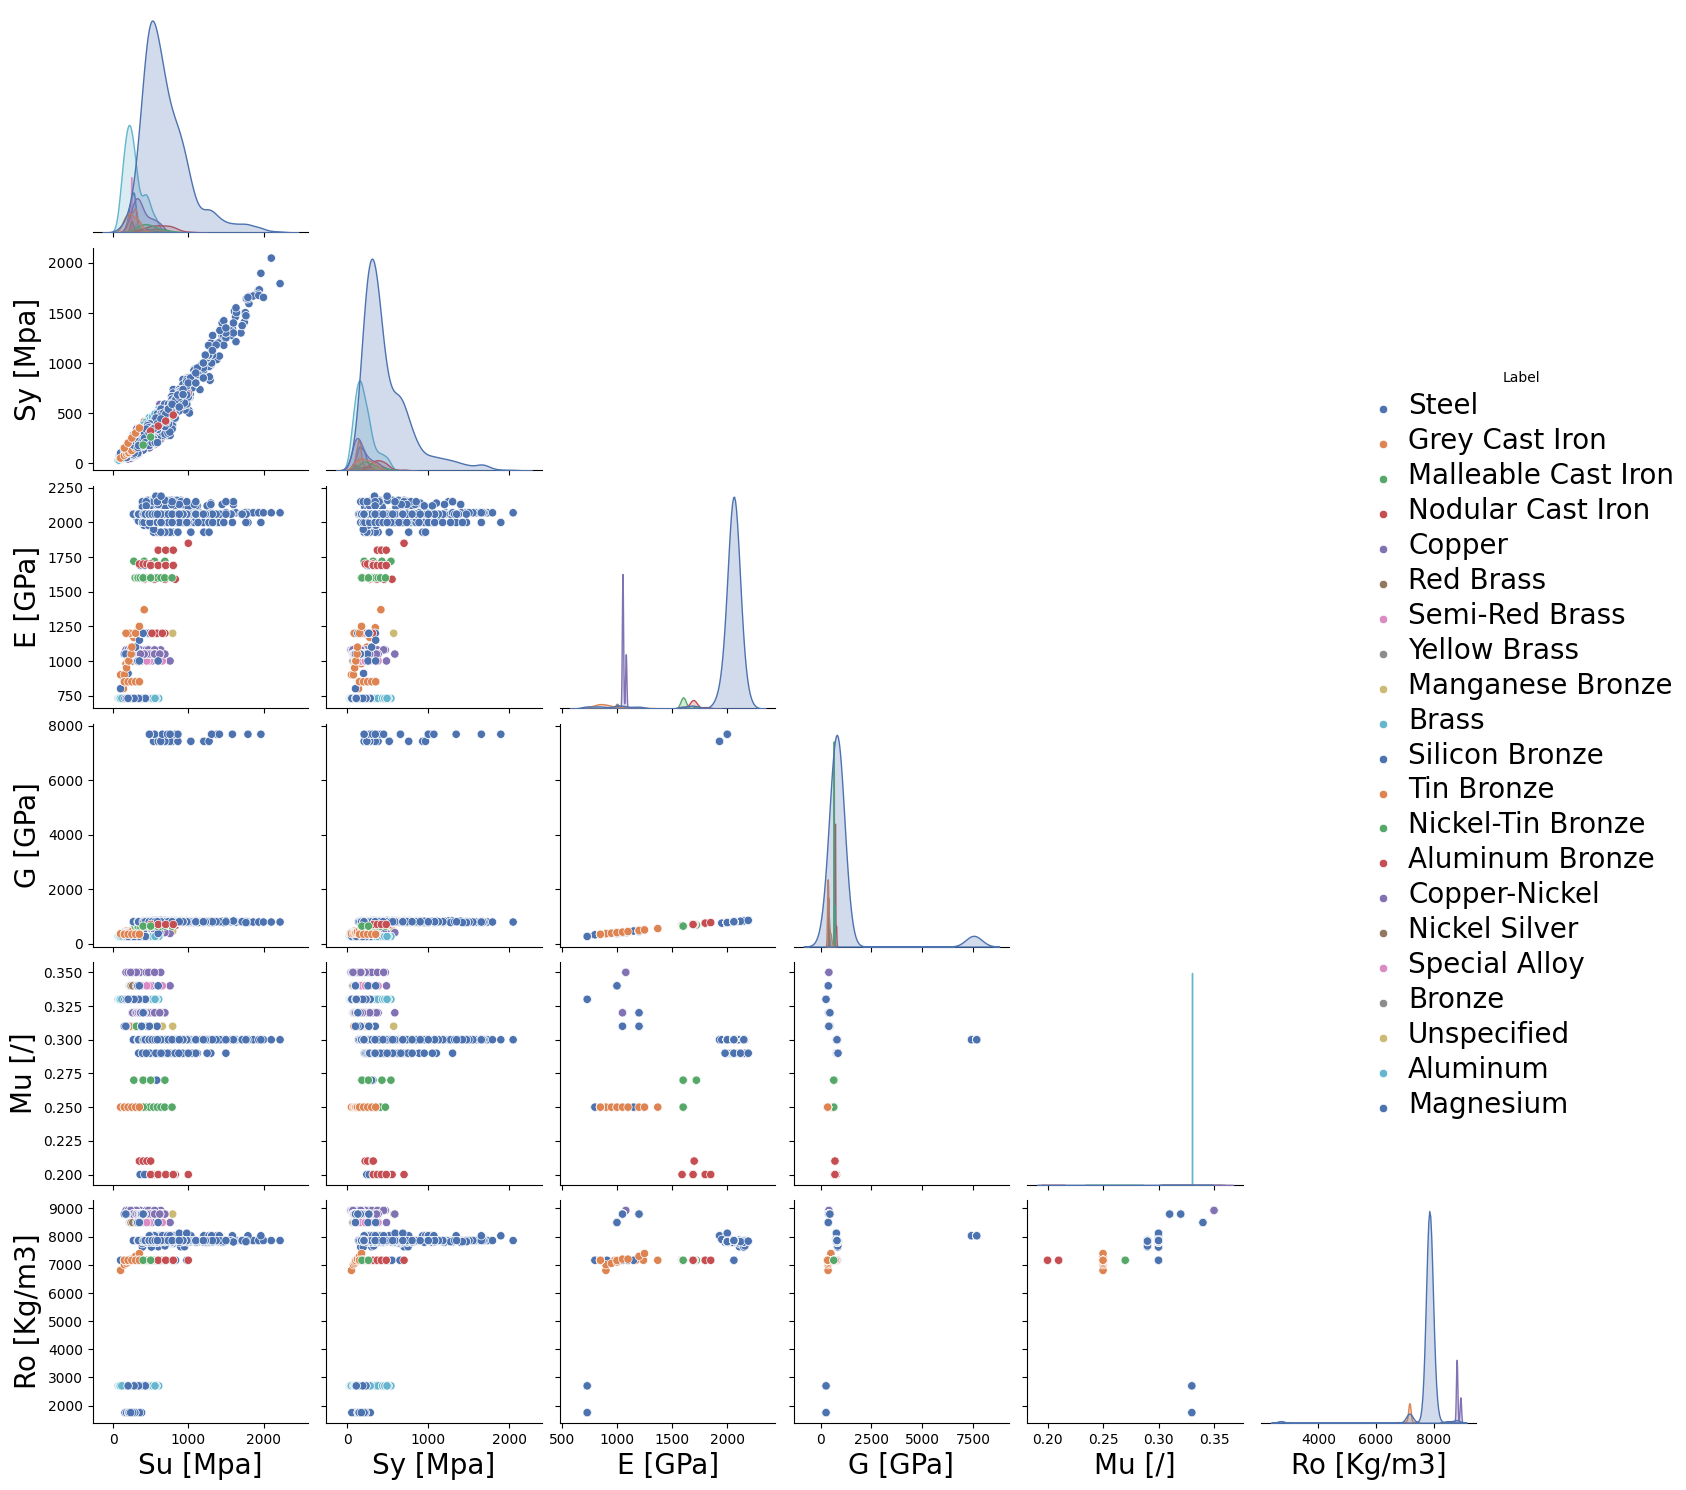

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

non_scaled = "FineGranularityMaterialGroups - Pair Plot.csv"
d_p = pd.read_csv(non_scaled)
d_p['E [GPa]'] = d_p['E [GPa]'] / 100
d_p['G [GPa]'] = d_p['G [GPa]'] / 100

palette = {
    'Steel': (0.9678, 0.4413, 0.5358),
    'Grey Cast Iron': (0.9703, 0.4594, 0.3267),
    'Malleable Cast Iron': (0.8729, 0.5302, 0.1956),
    'Nodular Cast Iron': (0.7757, 0.5785, 0.1948),
    'Copper': (0.6960, 0.6098, 0.1942),
    'Red Brass': (0.6148, 0.6356, 0.1936),
    'Semi-Red Brass': (0.5105, 0.6614, 0.1931),
    'Yellow Brass': (0.3127, 0.6929, 0.1924),
    'Manganese Bronze': (0.1987, 0.6943, 0.4223),
    'Brass': (0.2043, 0.6864, 0.5407),
    'Silicon Bronze': (0.2085, 0.6802, 0.6131),
    'Tin Bronze': (0.2124, 0.6744, 0.6723),
    'Nickel-Tin Bronze': (0.2166, 0.6677, 0.7319),
    'Aluminum Bronze': (0.2224, 0.6582, 0.8058),
    'Copper-Nickel': (0.2330, 0.6396, 0.9261),
    'Nickel Silver': (0.5049, 0.5909, 0.9585),
    'Special Alloy': (0.6816, 0.5347, 0.9582),
    'Bronze': (0.8303, 0.4590, 0.9579),
    'Unspecified': (0.9587, 0.3662, 0.9231),
    'Aluminum': (0.9626, 0.4003, 0.7888),
    'Magnesium': (0.9653, 0.4222, 0.6727)
}


pair_plot = sns.pairplot(d_p, hue="Label", palette = sns.color_palette("deep", 21), corner=True)

# Get the default font size (assuming it's 10) and multiply by 5
default_font_size = 10
enhanced_font_size = default_font_size * 2

# Adjusting the font size of axis labels
for ax in pair_plot.axes.flatten():
    if ax is not None:
        # Set the enhanced font size for x-axis and y-axis labels
        ax.set_xlabel(ax.get_xlabel(), fontsize=enhanced_font_size)
        ax.set_ylabel(ax.get_ylabel(), fontsize=enhanced_font_size)

# Adjusting the font size of legend labels
legend = pair_plot._legend
for text in legend.get_texts():
    text.set_fontsize(enhanced_font_size)

plt.show()

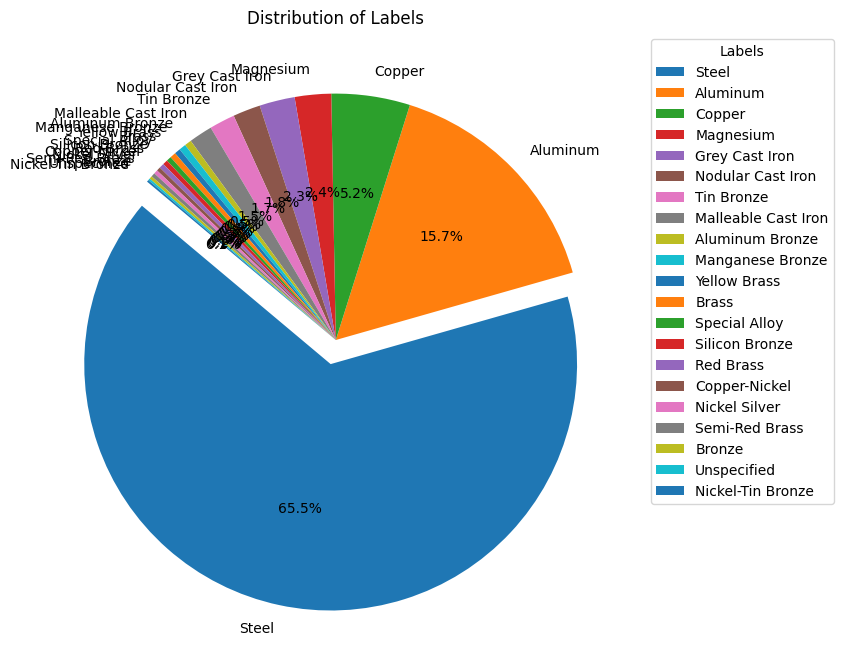

In [12]:
# Count the occurrences of each unique value in the 'Label' column
label_counts = d_p['Label'].value_counts()

# Define the explode values for each slice of the pie (to separate the slices a bit)
# For example, if you have 5 labels, you can set explode to [0.1, 0, 0, 0, 0] to separate the first slice
explode_values = [0.1 if i == 0 else 0 for i in range(len(label_counts))]

# Create a pie chart
plt.figure(figsize=(10, 8))  # Adjust the size of the figure as needed
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140, explode=explode_values)

# Add a legend with a bbox_to_anchor to place it outside the chart
plt.legend(title='Labels', loc='upper left', bbox_to_anchor=(1, 1))

# Add a title
plt.title('Distribution of Labels')

# Show the plot
plt.show()
